В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2'

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: olgatuka
Your Kaggle Key: ··········
Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_train_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/train.csv')

In [4]:
raw_train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [5]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


**Висновок.** В тренувальному наборі немає пропущених значень.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
y = raw_train_df['Exited']
stratify = y
train_df, val_df, y_train, y_val = train_test_split(raw_train_df, y, test_size=0.3, random_state=42, stratify=stratify)
train_df.shape, val_df.shape

((10500, 14), (4500, 14))

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [8]:
input_cols = list(train_df.columns)[:-1]
target_col = 'Exited'

input_cols

['id',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [9]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [10]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

**4.1. Вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі**

Видаляємо наступні колонки:
 - **id**: унікальний ідентифікатор рядка не має прямого зв'язку з цільовою змінною
 - **CustomerId**: (1) має бути унікальним для кожного клієнта, тому не допомагає знайти закономірності для прогнозування цільової змінної; (2) у нових даних будуть нові унікальні ID, які будуть незнайомі моделі.
 - **Surname**: (1) у більшості випадків прізвище не буде мати прямого зв'язку з нашою цільовою змінною; (2) може нараховувати сотні (або навіть тисячі) унікальних значень, які складно буде закодувати ефективно.  

In [11]:
col_to_del = ['id', 'CustomerId', 'Surname']

train_inputs.drop(columns=col_to_del, inplace=True)
val_inputs.drop(columns=col_to_del, inplace=True)

display(train_inputs.head(), val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8414,741.0,Spain,Female,39.0,3.0,0.00,1.0,0.0,1.0,135875.51
578,699.0,Spain,Male,30.0,8.0,0.00,1.0,0.0,0.0,91514.62
12060,642.0,Spain,Male,34.0,4.0,0.00,2.0,1.0,0.0,147554.26
9903,638.0,France,Male,33.0,7.0,126588.81,2.0,1.0,0.0,149535.97
4589,712.0,France,Male,31.0,1.0,0.00,2.0,1.0,0.0,166677.54


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3689,641.0,France,Female,32.0,1.0,0.00,2.0,0.0,0.0,152987.42
1861,670.0,France,Female,54.0,7.0,0.00,1.0,1.0,1.0,162599.51
13593,629.0,France,Male,42.0,7.0,0.00,1.0,0.0,0.0,99843.95
4778,572.0,France,Male,31.0,6.0,145965.33,2.0,1.0,1.0,177844.06
13876,637.0,Spain,Male,38.0,5.0,0.00,2.0,1.0,0.0,36706.56


In [12]:
# Оновлюємо списки числових та категоріальних ознак

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

**4.2. Заповнення пропущених значень, якщо вони є**

Як ми пам'ятаємо з попереднього аналізу за допомогою **raw_train_df.info()** наш датасет не має пропущених значень, тому цей пункт пропускаємо.

**4.3. Масштабування числових ознак**

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [16]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

display(train_inputs[numeric_cols].describe().round(2), val_inputs[numeric_cols].describe().round(2))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00
mean,0.54,0.36,0.50,0.21,0.20,0.79,0.49,0.59
std,0.17,0.15,0.28,0.29,0.18,0.40,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.26,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.55,0.35,0.50,0.00,0.33,1.00,0.00,0.62
75%,0.66,0.44,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,4500.00,4500.00,4500.00,4500.00,4500.00,4500.00,4500.00,4500.00
mean,0.54,0.37,0.50,0.20,0.20,0.78,0.49,0.59
std,0.17,0.16,0.28,0.28,0.18,0.42,0.50,0.23
min,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.26,0.30,0.00,0.00,1.00,0.00,0.41
50%,0.55,0.35,0.50,0.00,0.33,1.00,0.00,0.61
75%,0.66,0.44,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.04,1.00,0.89,1.00,1.00,1.00,1.00


**4.4. Кодування категоріальних ознак**

In [17]:
print(train_inputs[categorical_cols].nunique())
print(val_inputs[categorical_cols].nunique())

Geography    3
Gender       2
dtype: int64
Geography    3
Gender       2
dtype: int64


In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [19]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [20]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [21]:
encoder.transform(train_inputs[categorical_cols])

array([[0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.]])

In [22]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [ ]:
train_inputs

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
8414,0.739857,Spain,Female,0.388889,0.3,0.000000,0.000000,0.0,1.0,0.679385,0.0,0.0,1.0,1.0,0.0
578,0.639618,Spain,Male,0.222222,0.8,0.000000,0.000000,0.0,0.0,0.457559,0.0,0.0,1.0,0.0,1.0
12060,0.503580,Spain,Male,0.296296,0.4,0.000000,0.333333,1.0,0.0,0.737784,0.0,0.0,1.0,0.0,1.0
9903,0.494033,France,Male,0.277778,0.7,0.603473,0.333333,1.0,0.0,0.747693,1.0,0.0,0.0,0.0,1.0
4589,0.670644,France,Male,0.240741,0.1,0.000000,0.333333,1.0,0.0,0.833409,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13749,0.248210,Germany,Male,0.555556,0.2,0.672357,0.000000,0.0,0.0,0.588161,0.0,1.0,0.0,0.0,1.0
2871,0.491647,Germany,Female,0.537037,0.4,0.490804,0.000000,1.0,0.0,0.514745,0.0,1.0,0.0,1.0,0.0
8839,0.971360,France,Male,0.518519,0.9,0.000000,0.000000,0.0,1.0,0.719789,1.0,0.0,0.0,0.0,1.0
11512,0.379475,Spain,Male,0.444444,0.7,0.000000,0.333333,0.0,0.0,0.363197,0.0,0.0,1.0,0.0,1.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [23]:
!pip install pyarrow --quiet

In [24]:
train_inputs.to_parquet('./bank-customer-churn-prediction-dlu-course-c-2/train_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('./bank-customer-churn-prediction-dlu-course-c-2/train_targets.parquet')

val_inputs.to_parquet('./bank-customer-churn-prediction-dlu-course-c-2/val_inputs.parquet')
pd.DataFrame(val_targets).to_parquet('./bank-customer-churn-prediction-dlu-course-c-2/val_targets.parquet')


In [25]:
!ls ./bank-customer-churn-prediction-dlu-course-c-2

sample_submission.csv  train_inputs.parquet   val_targets.parquet
test.csv	       train_targets.parquet
train.csv	       val_inputs.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [26]:
# Створення наборів X_train, X_val, y_train, y_val

X_train = train_inputs[numeric_cols + encoded_cols]
y_train = train_targets
X_val = val_inputs[numeric_cols + encoded_cols]
y_val = val_targets

display(X_train.head(), X_val.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
8414,0.739857,0.388889,0.3,0.000000,0.000000,0.0,1.0,0.679385,0.0,0.0,1.0,1.0,0.0
578,0.639618,0.222222,0.8,0.000000,0.000000,0.0,0.0,0.457559,0.0,0.0,1.0,0.0,1.0
12060,0.503580,0.296296,0.4,0.000000,0.333333,1.0,0.0,0.737784,0.0,0.0,1.0,0.0,1.0
9903,0.494033,0.277778,0.7,0.603473,0.333333,1.0,0.0,0.747693,1.0,0.0,0.0,0.0,1.0
4589,0.670644,0.240741,0.1,0.000000,0.333333,1.0,0.0,0.833409,1.0,0.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
3689,0.501193,0.259259,0.1,0.000000,0.333333,0.0,0.0,0.764952,1.0,0.0,0.0,1.0,0.0
1861,0.570406,0.666667,0.7,0.000000,0.000000,1.0,1.0,0.813017,1.0,0.0,0.0,1.0,0.0
13593,0.472554,0.444444,0.7,0.000000,0.000000,0.0,0.0,0.499210,1.0,0.0,0.0,0.0,1.0
4778,0.336516,0.240741,0.6,0.695844,0.333333,1.0,1.0,0.889247,1.0,0.0,0.0,0.0,1.0
13876,0.491647,0.370370,0.5,0.000000,0.333333,1.0,0.0,0.183492,0.0,0.0,1.0,0.0,1.0


In [27]:
# Тренування логістичної регресії

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')

model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [28]:
# Передбачення за допомогою натренованої моделі

y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_val)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [29]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc

In [30]:
def predict_and_plot_new(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    #print(f"Accuracy {name}: {accuracy:.4f}")

    f1_score_ = f1_score(targets, preds, pos_label=1)
    #print(f"F1 score {name}: {f1_score_:.4f}")

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle('{} dataset'.format(name), fontsize = 16)

    # Confusion matrix
    cf = confusion_matrix(targets, preds, normalize='true')
    cf_ = confusion_matrix(targets, preds)

    # Create custom labels for confusion matrix
    labels_names = ['True Neg','False Pos','False Neg','True Pos']
    labels_counts = ['{0:0.0f}'.format(value) for value in cf_.flatten()]
    labels_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels_names, labels_counts, labels_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Plot the confusion matrix
    sns.heatmap(cf, ax = ax[0], annot = labels, fmt = '')
    ax[0].set_title('{} Confusion Matrix'.format(name), fontsize = 10)
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Target')

    # Predict probabilities
    preds_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, preds_proba, pos_label=1)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    #print(f'AUROC for {name}: {roc_auc:.4f}')

    # Plot the ROC curve
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_title(f'Receiver Operating Characteristic (ROC) Curve for {name}', fontsize = 10)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])


    # Plot accuracy metrics
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title(f'{name} accuracy metrics', fontsize = 10)
    ax[2].text(0.5, 0.7, f'Accuracy: {accuracy:.4f}', fontsize=12, ha='center')
    ax[2].text(0.5, 0.5, f'F1 score: {f1_score_:.4f}', fontsize=12, ha='center')
    ax[2].text(0.5, 0.3, f'AUROC: {roc_auc:.4f}', fontsize=16, color='darkorange', ha='center')

    plt.show()

    return preds, preds_proba

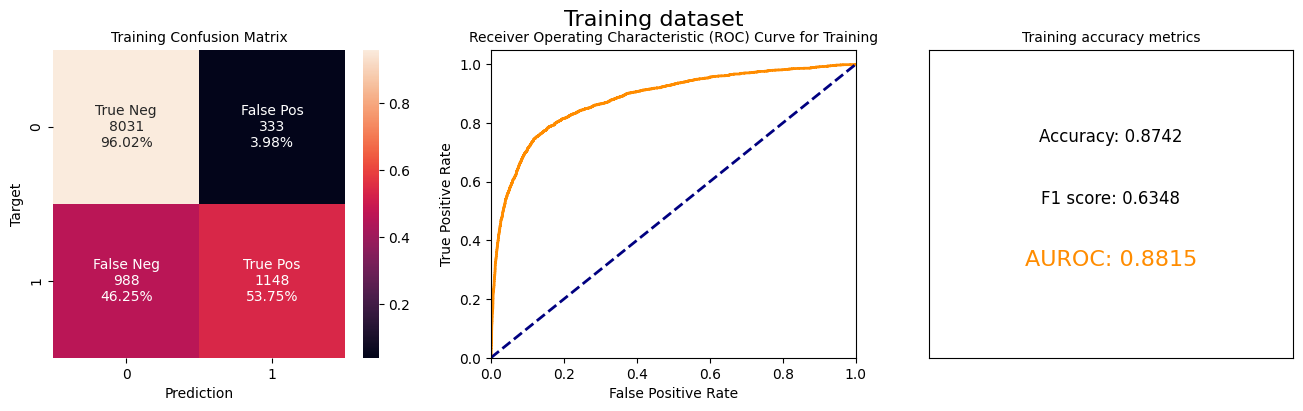

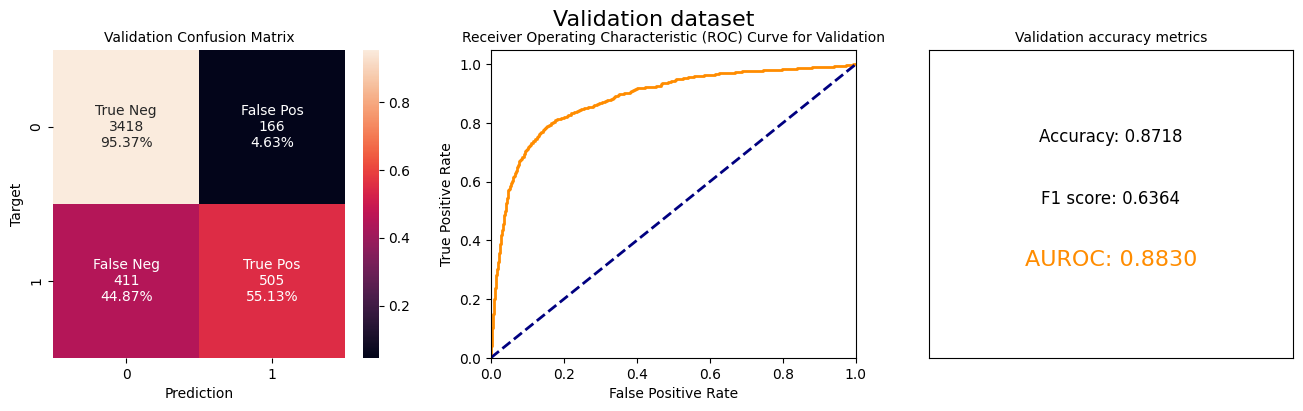

In [31]:
y_train_preds, y_train_preds_proba = predict_and_plot_new(X_train, y_train, 'Training')
y_val_preds, y_val_preds_proba = predict_and_plot_new(X_val, y_val, 'Validation')

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [32]:
# Визначення мажоритарного класу в тренувальних даних

y_train.value_counts(normalize = True)

,proportion
Exited,
0.0,0.796571
1.0,0.203429


In [33]:
# Функція для створення передбачень, рівних 0 (як більшість значень нашої цільової змінної в тренувальних даних)

def all_no(inputs):
    return np.full(len(inputs), 0)

acc_no_train = accuracy_score(y_train, all_no(X_train))
acc_no_val = accuracy_score(y_val, all_no(X_val))

accuracy_train = accuracy_score(y_train, y_train_preds)
accuracy_val = accuracy_score(y_val, y_val_preds)

print(f"Accuracy score for training data with trained log_reg_model: \t{accuracy_train*100:.2f}%")
print(f"Accuracy score for training data with all_no_model: \t\t{acc_no_train*100:.2f}%")

print(f"\nAccuracy score for validation data with trained log_reg_model: \t{accuracy_val*100:.2f}%")
print(f"Accuracy score for validation data with all_no_model: \t\t{acc_no_val*100:.2f}%")


Accuracy score for training data with trained log_reg_model: 	87.42%
Accuracy score for training data with all_no_model: 		79.66%

Accuracy score for validation data with trained log_reg_model: 	87.18%
Accuracy score for validation data with all_no_model: 		79.64%


Точність нашої моделі вище ніж точність моделі, яка завжди передбачає клас **0** (No). Це вже є хорошою ознакою.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [34]:
import joblib

customer_churn = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'col_to_del': col_to_del,
    'encoded_cols': encoded_cols
}

joblib.dump(customer_churn, './bank-customer-churn-prediction-dlu-course-c-2/log_reg.joblib')

['./bank-customer-churn-prediction-dlu-course-c-2/log_reg.joblib']

In [35]:
customer_churn_2 = joblib.load('./bank-customer-churn-prediction-dlu-course-c-2/log_reg.joblib')

model_2 = customer_churn_2['model']
model_2

LogisticRegression(solver='liblinear')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [36]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, col_to_del, input_df: pd.DataFrame):
    input_df.drop(columns=col_to_del, inplace=True)
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [37]:
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/test.csv')
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [38]:
y_test_prob = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, col_to_del, test_raw_df)
y_test_prob

array([0.07645988, 0.03559573, 0.15148409, ..., 0.01917785, 0.15478437,
       0.09117168])

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [39]:
df_to_submit = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')

df_to_submit.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [40]:
# Заповнюємо колонку Exited передбаченими значеннями y_test_prob

df_to_submit['Exited'] = y_test_prob
df_to_submit.head()

,id,Exited
0,15000,0.076460
1,15001,0.035596
2,15002,0.151484
3,15003,0.194430
4,15004,0.057497


In [41]:
# Зберігаємо результат в файл submission_log_reg.csv

df_to_submit.to_csv('./bank-customer-churn-prediction-dlu-course-c-2/submission_log_reg.csv', index = False)